# BayesCPi Analysis

In [1]:
#using Pkg
#Pkg.add("ProgressMeter") 

In [2]:
using Distributions
using Plots           
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames
using ProgressMeter

┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184


In [3]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end

readMatBin (generic function with 1 method)

In [4]:
beta = readdlm("beta.csv")
y    = readdlm("phenotypes.csv")
Markers = readMatBin("genotypes.bin")
M = Markers .- mean(Markers,dims=1)
mean(M,dims=1)

1×2241 Array{Float64,2}:
 -8.21565e-17  -3.28626e-17  -7.10543e-17  …  -9.9476e-17  -8.88178e-18

## Initialize variables

In [5]:
nIter  = 2100
burnin = 101   # actually burnin + 1
n,k = size(M)
mean2pq = mean(var(M,dims=1))
pi  = 0.5
Ve  = var(y)/2
Va  = Ve/((1-pi)*k*mean2pq)       
α   = zeros(k)
δ   = ones(k)                 # indicator for variable selection  
mu  = 0
meanAlpha = zeros(k)
meanMu = 0
w = y .- mu - M*(α.*δ);            # y adjusted for intercept and marker effects
samplesVa = zeros(nIter)
samplesVe = zeros(nIter)
samplesPi = zeros(nIter)
samplesα  = zeros(k,nIter)
νa = 4.0
νe = 4.0
S2a = Va*(νa-2)/νa
S2e = Ve*(νe-2)/νe

1.1553091285902046

## Loop for MCMC samples

In [6]:
@showprogress "obtaining MCMC samples for BayesC0..." for i=1:nIter
    # sample intercept
    global w,mu, meanMu, α, meanAlpha, Ve, Va, pi
    w = w .+ mu                       # add the effect of mu 
    meanMu = mean(w)
    std = sqrt(Ve/n)
    mu = meanMu + randn()*std
    meanMu += (mu - meanMu)/i
    w = w .- mu                       # adjust for sampled mu
    λ = Ve/Va
    j = 1
    logPi     = log(pi)
    logPiComp = log(1-pi)
    for j = 1:k
        x = M[:,j]
        w = w .+ x*α[j]*δ[j]          # add the effect of marker effect j
        # sample δ_j
        logh1 = logPiComp - sum((w-x*α[j]).^2)/(2Ve)
        logh0 = logPi     - sum((w).^2)/(2Ve)
        prδ1 = 1.0/(1.0 + exp(logh0 - logh1))
        δ[j] = rand() < prδ1 ? 1 : 0

        # sample marker effect
        lhs = (x'x*δ[j] + λ)[1]
        rhs = (x'w*δ[j])[1]
        meanAlpha_j = rhs/lhs
        std = sqrt(Ve/lhs)
        α[j] = meanAlpha_j + randn()*std
        w -= x*α[j]*δ[j]              # adjust for marker effect j
    end
    samplesα[:,i] = α.*δ
    # sample Va
    Va = (α'α + νa*S2a)/rand(Chisq(k+νa),1)[1]
    samplesVa[i] = Va
    # sample Ve
    Ve = ((w'w)[1] + νe*S2e)/rand(Chisq(n+νe),1)[1]
    samplesVe[i] = Ve
    # sample pi
    sumδ1 = sum(δ)
    a = k - sumδ1 + 1
    b = sumδ1 + 1
    pi = rand(Beta(a,b))
    samplesPi[i] = pi
end

obtaining MCMC samples for BayesC0...100%|██████████████| Time: 0:04:59


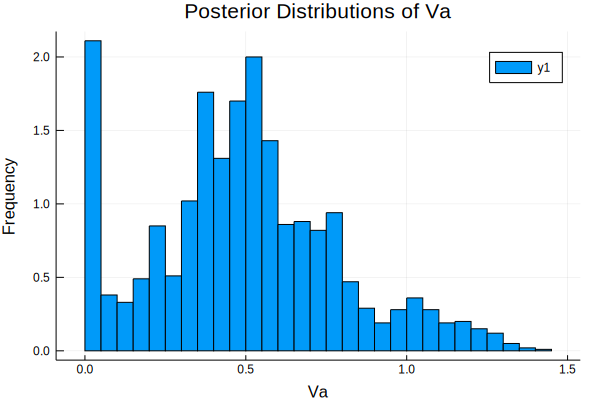

In [7]:
histogram(samplesVa[burnin:end],nbins=50,normed=true,
title  = "Posterior Distributions of Va",
ylabel = "Frequency", 
xlabel = "Va")

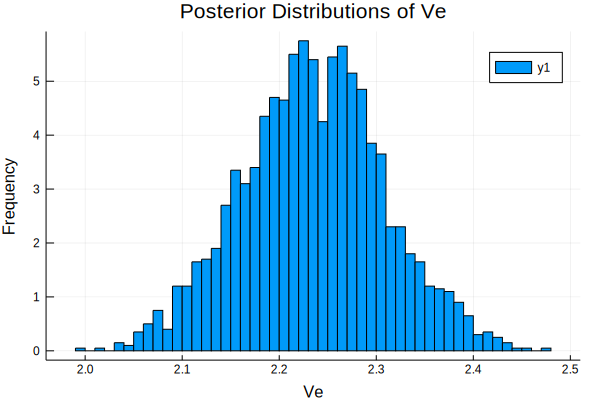

In [8]:
histogram(samplesVe[burnin:end],nbins=50,normed=true,
title  = "Posterior Distributions of Ve",
ylabel = "Frequency", 
xlabel = "Ve")

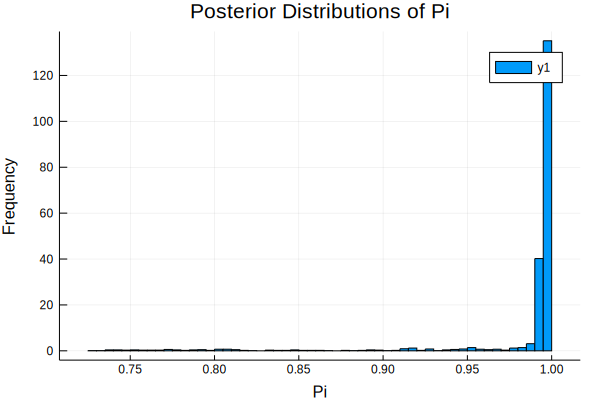

In [9]:
histogram(samplesPi[burnin:end],nbins=50,normed=true,
title  = "Posterior Distributions of Pi",
ylabel = "Frequency", 
xlabel = "Pi")

In [10]:
function winPPA(M,samplesα,win)
    wPPA = zeros(nIter)
    nSamples = size(samplesα,2)
    for i=1:nSamples
        genVar = var(M*samplesα[:,i])
        winVar = var(M[:,win]*samplesα[win,i])
        wPPA[i] = winVar/genVar
    end
    wPPA
end

winPPA (generic function with 1 method)

In [11]:
wStarts = [80,100,120,300,400,500]
wSize   = 20
[sum(winPPA(M,samplesα,i:i+wSize)[burnin:end] .> 0.1)/(nIter-burnin+1) for i in wStarts]

6-element Array{Float64,1}:
 0.0   
 0.997 
 0.0   
 0.9325
 0.0   
 0.887 